In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.interpolate import griddata
import cartopy.crs as ccrs
from matplotlib.animation import FuncAnimation
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d as histo2D

c:\Users\virtanem\Anaconda3\envs\gradu\Lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
path = 'data/filtered2013.csv'

dtypes = {'gps_site': str,
 'sat_id': str,
 'gdlatr': float,
 'gdlonr': float,
 'los_tec': float,
 'tec': float,
 'azm': float,
 'elm': float,
 'gdlat': float,
 'glon': float,
 'gnss_type': str,
 'slant_f': float,
 'vtec': float,
 'pair_id': str,
 'curve_id': int,
 'filtered': float,
 'blrmvd': float}

raw = pd.read_csv(path, dtype=dtypes)

raw['datetime'] = pd.to_datetime(raw['datetime'])

## Delete the first and last 15 mins of each curve + elevation filter + filter out night time data + change interval to 1 minute

In [3]:
MIN_ELEVATION = 20
DAYTIME = [6, 18]

def trim_curve(group):
    group = group.sort_values('datetime')
    start_time = group['datetime'].iloc[0] + timedelta(minutes=15)
    end_time = group['datetime'].iloc[-1] - timedelta(minutes=15)
    return group[(group['datetime'] >= start_time) & (group['datetime'] <= end_time)]

data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)

data = data[(data['datetime'].dt.hour >=  DAYTIME[0]) & 
            (data['datetime'].dt.hour < DAYTIME[1]) & 
            (data['elm'] > MIN_ELEVATION)]

data['datetime'] = data['datetime'].dt.floor('T')

C:\Users\virtanem\AppData\Local\Temp\ipykernel_9424\4274386050.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)
C:\Users\virtanem\AppData\Local\Temp\ipykernel_9424\4274386050.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data['datetime'] = data['datetime'].dt.floor('T')


## Creating the animation

### pierce points

MovieWriter ffmpeg unavailable; using Pillow instead.


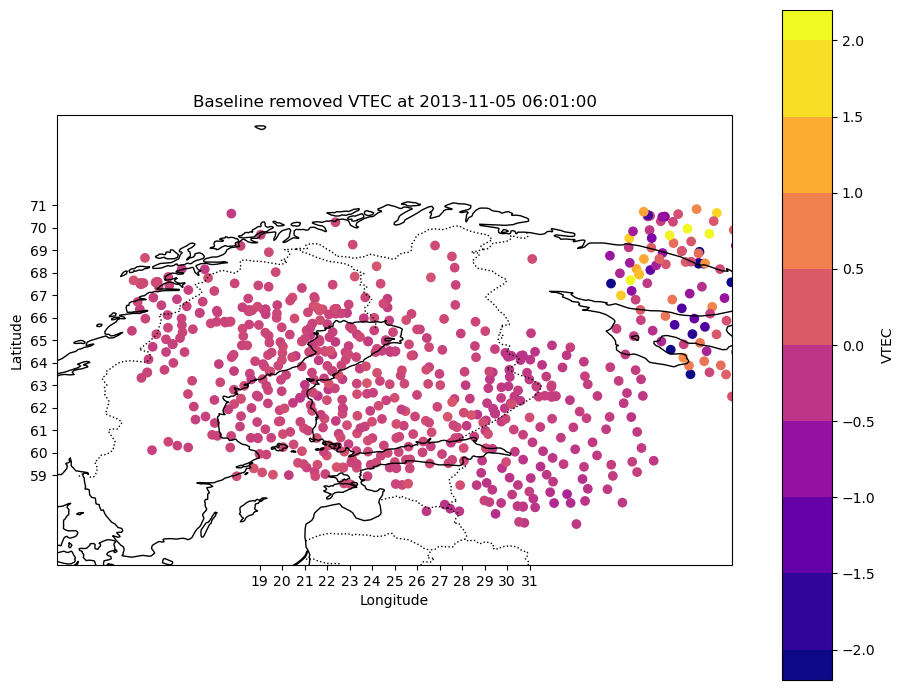

In [4]:
def pp(frame):
    df1 = data.loc[data['datetime'] == frame]
    ax.set_title(f'Baseline removed VTEC at {frame}')

    for c in ax.collections:
        c.remove()

    ax.scatter(df1['glon'], df1['gdlat'],c= df1['blrmvd'], cmap='plasma', vmin=-2, vmax=2)

    

frames = sorted(data['datetime'].unique())
df0 = data.loc[data['datetime'] == frames[0]]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_xticks(np.arange(19, 32, 1))
ax.set_yticks(np.arange(59, 72, 1))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(10, 40)
ax.set_ylim(55, 75)

contour = ax.scatter(df0['glon'], df0['gdlat'],c= df0['blrmvd'], cmap='plasma', vmin=-2, vmax=2)

fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                    extendrect = True, label='VTEC',
                    ticks=np.arange(-2,2.5,0.5),
                    boundaries = np.arange(-2,2.5,0.5), 
                    extend='both'
)

animation = FuncAnimation(fig, pp, frames=frames[1:], interval=30)

animation.save('pp_animation.gif')

### 2D histogram

MovieWriter ffmpeg unavailable; using Pillow instead.


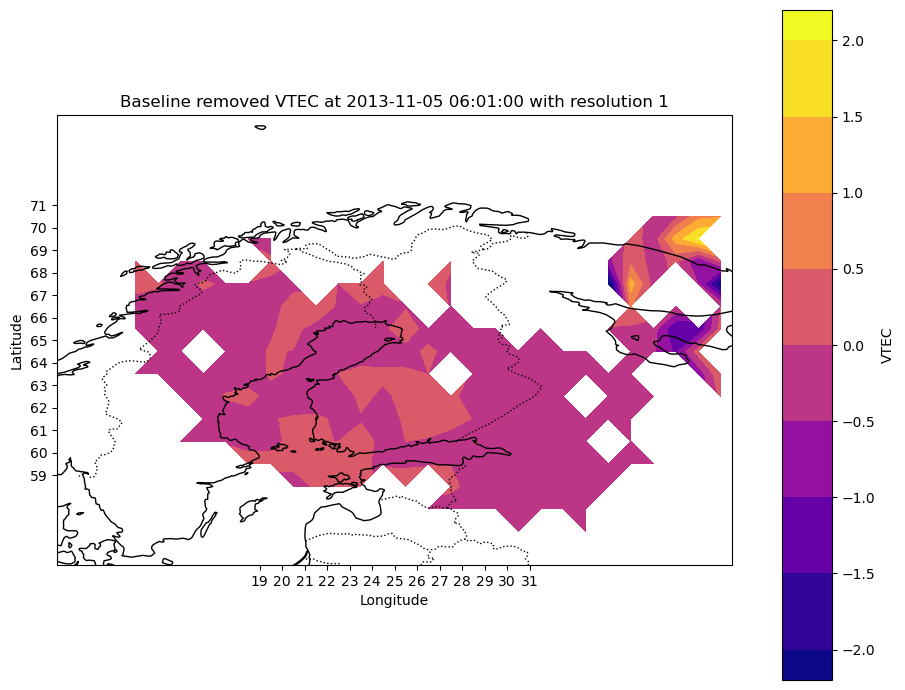

In [5]:
RES = 1

def histo(frame):
    df1 = data.loc[data['datetime'] == frame]
    ax.set_title(f'Baseline removed VTEC at {frame} with resolution {RES}')

    statistic, x_edges, y_edges, _ = histo2D(
        df1['glon'], df1['gdlat'], df1['blrmvd'], statistic='mean', 
        bins=[np.arange(10, 40 + RES, RES), np.arange(55, 75 + RES, RES)])

    X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)
    
    for c in ax.collections:
        c.remove()
    
    ax.contourf(X, Y, statistic.T, cmap='plasma', vmin=-2, vmax=2, 
                        levels=np.linspace(-2, 2, 9), 
                        extend='both', transform=ccrs.PlateCarree())
    
    
    

frames = sorted(data['datetime'].unique())
df0 = data.loc[data['datetime'] == frames[0]]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_xticks(np.arange(19, 32, 1))
ax.set_yticks(np.arange(59, 72, 1))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(10, 40)
ax.set_ylim(55, 75)
ax.set_title(f'Baseline removed VTEC at {frames[0]} with resolution {RES}')

statistic, x_edges, y_edges, _ = histo2D(
    df0['glon'], df0['gdlat'], df0['blrmvd'], statistic='mean', 
    bins=[np.arange(10, 40 + RES, RES), np.arange(55, 75 + RES, RES)])

X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)
ax.contourf(X, Y, statistic.T, cmap='plasma', vmin=-2, vmax=2, 
                    levels=np.linspace(-2, 2, 9), 
                    extend='both', transform=ccrs.PlateCarree())
    


fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                    extendrect = True, label='VTEC',
                    ticks=np.arange(-2,2.5,0.5),
                    boundaries = np.arange(-2,2.5,0.5), 
                    extend='both'
)


animation = FuncAnimation(fig, histo, frames=frames[1:], interval=30)

animation.save('heatmap_animation_h.gif')

### pcolormesh

MovieWriter ffmpeg unavailable; using Pillow instead.


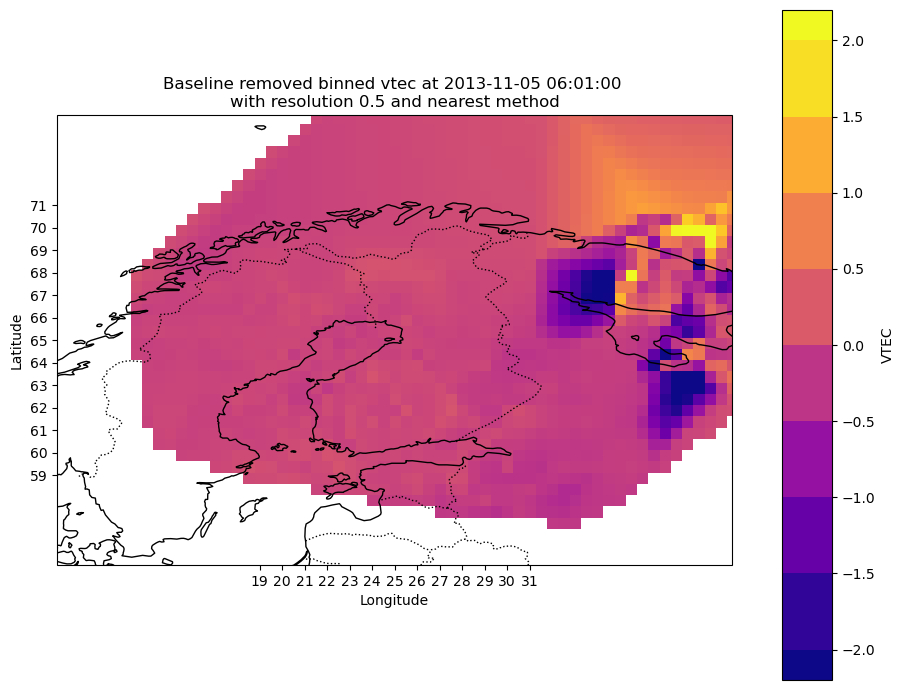

In [6]:
METHOD = 'nearest'
RES = 0.5

def mesh(frame):
    df1 = data.loc[data['datetime'] == frame]
    ax.set_title(f'Baseline removed binned vtec at {frame} \nwith resolution {RES} and {METHOD} method')
    Z = griddata((df1['glon'], df1['gdlat']), df1['blrmvd'], (X, Y))

    for c in ax.collections:
        c.remove()

    ax.pcolormesh(x_grid, y_grid, Z, cmap='plasma', shading='nearest', vmin=-2, vmax=2)


frames = sorted(data['datetime'].unique())
df0 = data.loc[data['datetime'] == frames[0]]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_xticks(np.arange(19, 32, 1))
ax.set_yticks(np.arange(59, 72, 1))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(10, 40)
ax.set_ylim(55, 75)
ax.set_title(f'Baseline removed binned vtec at {frames[0]} \nwith resolution {RES} and {METHOD} method')

x_grid = np.arange(min(data['glon']), max(data['glon']) + RES, RES)
y_grid = np.arange(min(data['gdlat']), max(data['gdlat']) + RES, RES)
X, Y = np.meshgrid(x_grid, y_grid)
Z = griddata((df0['glon'], df0['gdlat']), df0['blrmvd'], (X, Y))

contour = ax.pcolormesh(x_grid, y_grid, Z, cmap='plasma', shading='nearest', vmin=-2, vmax=2)    



fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                    extendrect = True, label='VTEC',
                    ticks=np.arange(-2,2.5,0.5),
                    boundaries = np.arange(-2,2.5,0.5), 
                    extend='both'
)


animation = FuncAnimation(fig, mesh, frames=frames[1:], interval=30)

animation.save('heatmap_animation_p.gif')